In [1]:
import scanpy as sc
import pandas as pd
import celltypist
import json
import matplotlib.pyplot as plt
from celltypist import models

RANDOM_STATE = 42
RESULTS_FOLDER = 'results/'
DATA_PATH = 'GSE194078'
MODEL_PATH = 'results/Immune_All_High_GSE239626_model.pkl'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Import New Dataset

In [2]:
adata = sc.read(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 110565 × 36601
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [3]:
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [4]:
adata.X

<110565x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 221207022 stored elements in Compressed Sparse Row format>

### Predictions

In [5]:
predictions = celltypist.annotate(
    adata,
    model=MODEL_PATH,
    majority_voting=True,
    mode='best match'
    )

🔬 Input data has 110565 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
c:\Users\giuli\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [6]:
predictions

CellTypist prediction result for 110565 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 110565 query cells and 32 cell types
    probability_matrix: data frame with 110565 query cells and 32 cell types
    adata: AnnData object referred

In [7]:
predictions.predicted_labels.to_csv(RESULTS_FOLDER+'celltypist_transfer_labels_GSE194078.csv')

### Results

In [8]:
predictions.predicted_labels.head()

,predicted_labels,over_clustering,majority_voting
AAACCCACAAGACCGA-1-PBMC,Monocytes,706,Monocytes
AAACCCACACGGCACT-1-PBMC,T cells,763,T cells
AAACCCATCAGAATAG-1-PBMC,T cells,829,T cells
AAACGAAAGGTAAAGG-1-PBMC,T cells,332,T cells
AAACGAACACAGCCAC-1-PBMC,T cells,113,T cells


In [9]:
len(predictions.predicted_labels['predicted_labels'].unique())

23

In [10]:
adata.obs['predicted_labels'] = predictions.predicted_labels['predicted_labels']

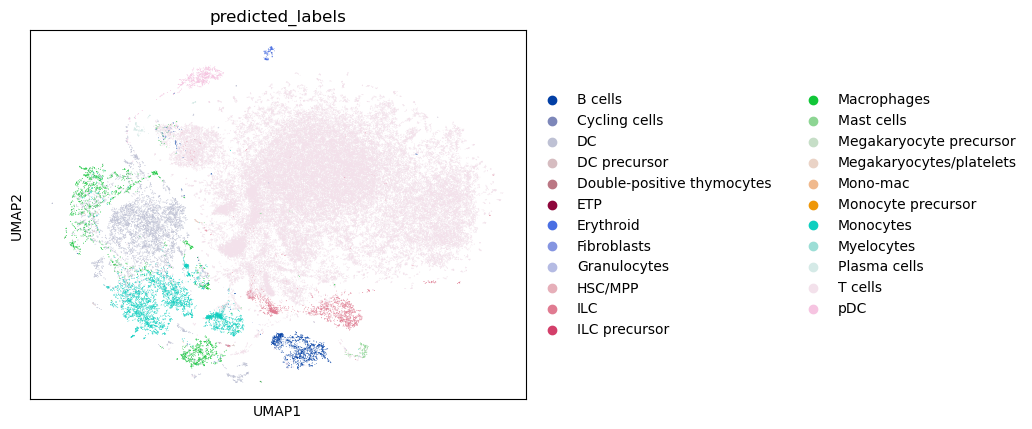

In [11]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['predicted_labels'], color_map='tab20')

In [12]:
adata.obs['predicted_labels'].value_counts()

predicted_labels
T cells                       90453
DC                             7673
Monocytes                      4904
Macrophages                    2506
ILC                            1941
B cells                        1546
pDC                             882
Plasma cells                    217
Mast cells                      160
Erythroid                       145
Megakaryocytes/platelets         29
Myelocytes                       22
Mono-mac                         19
DC precursor                     18
HSC/MPP                          14
Granulocytes                     13
Megakaryocyte precursor           6
Double-positive thymocytes        6
ETP                               5
Fibroblasts                       2
ILC precursor                     2
Cycling cells                     1
Monocyte precursor                1
Name: count, dtype: int64

In [13]:
labels = adata.obs['predicted_labels'].value_counts()[adata.obs['predicted_labels'].value_counts() > 1].index
labels

CategoricalIndex(['T cells', 'DC', 'Monocytes', 'Macrophages', 'ILC',
                  'B cells', 'pDC', 'Plasma cells', 'Mast cells', 'Erythroid',
                  'Megakaryocytes/platelets', 'Myelocytes', 'Mono-mac',
                  'DC precursor', 'HSC/MPP', 'Granulocytes',
                  'Megakaryocyte precursor', 'Double-positive thymocytes',
                  'ETP', 'Fibroblasts', 'ILC precursor'],
                 categories=['B cells', 'Cycling cells', 'DC', 'DC precursor', ..., 'Myelocytes', 'Plasma cells', 'T cells', 'pDC'], ordered=False, dtype='category', name='predicted_labels')

In [14]:
adata = adata[adata.obs['predicted_labels'].isin(labels)]
sc.tl.rank_genes_groups(adata, groupby='predicted_labels', method='t-test')
gene_groups = adata.uns['rank_genes_groups']

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:434: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

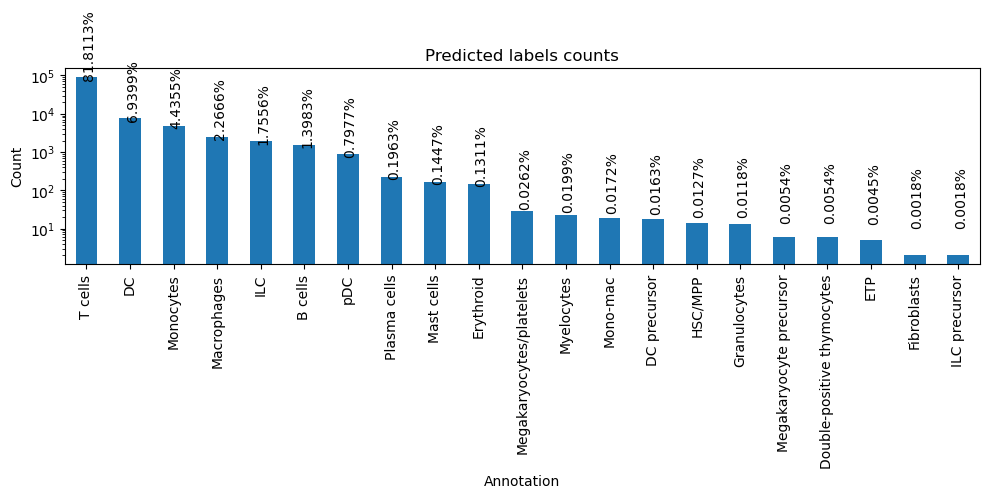

In [15]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
adata.obs['predicted_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata.obs['predicted_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Predicted labels counts')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [16]:
markers = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers[label] = gene_groups['names'][label].tolist()[:10] # top 10 markers, for each cell type

with open(RESULTS_FOLDER+'celltypist_markers_from_transfer_labels_GSE194078.json', 'w') as f:
    json.dump(markers, f)
    
print(markers)

{'Monocytes': ['S100A9', 'TYROBP', 'S100A8', 'FTL', 'CTSS', 'LST1', 'MNDA', 'AIF1', 'FCER1G', 'LYZ'], 'T cells': ['CD3D', 'CD3G', 'TRAC', 'CD3E', 'IL32', 'BCL11B', 'TRBC2', 'IL7R', 'LCK', 'LIME1'], 'Macrophages': ['TYROBP', 'HLA-DRA', 'AIF1', 'CST3', 'CD74', 'C1QA', 'C1QC', 'FCER1G', 'C1QB', 'FTH1'], 'DC': ['HLA-DRA', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DRB1', 'CST3', 'HLA-DQA1', 'HLA-DMA', 'HLA-DQB1', 'TYROBP'], 'pDC': ['CD74', 'TCF4', 'IRF8', 'HLA-DRA', 'CCDC50', 'PLAC8', 'UGCG', 'IRF7', 'PLD4', 'SERPINF1'], 'Fibroblasts': ['CTXN3', 'HMGCLL1', 'PDZRN4', 'HOXD-AS2', 'AC113349.1', 'COL11A1', 'SLC27A6', 'BMPR1B-DT', 'CNTFR', 'AGT'], 'Plasma cells': ['MZB1', 'JCHAIN', 'TXNDC5', 'DERL3', 'UBE2J1', 'POU2AF1', 'IGKC', 'TNFRSF17', 'CD79A', 'CD38'], 'ILC': ['CTSW', 'GNLY', 'KLRD1', 'NKG7', 'TYROBP', 'TRDC', 'ID2', 'KLRB1', 'XCL2', 'HOPX'], 'DC precursor': ['TUBA1B', 'HLA-DPB1', 'HLA-DRA', 'HMGN2', 'ACTB', 'CST3', 'CD74', 'AIF1', 'MKI67', 'HMGB1'], 'B cells': ['HLA-DRA', 'CD79A', 'CD74', 'MS4

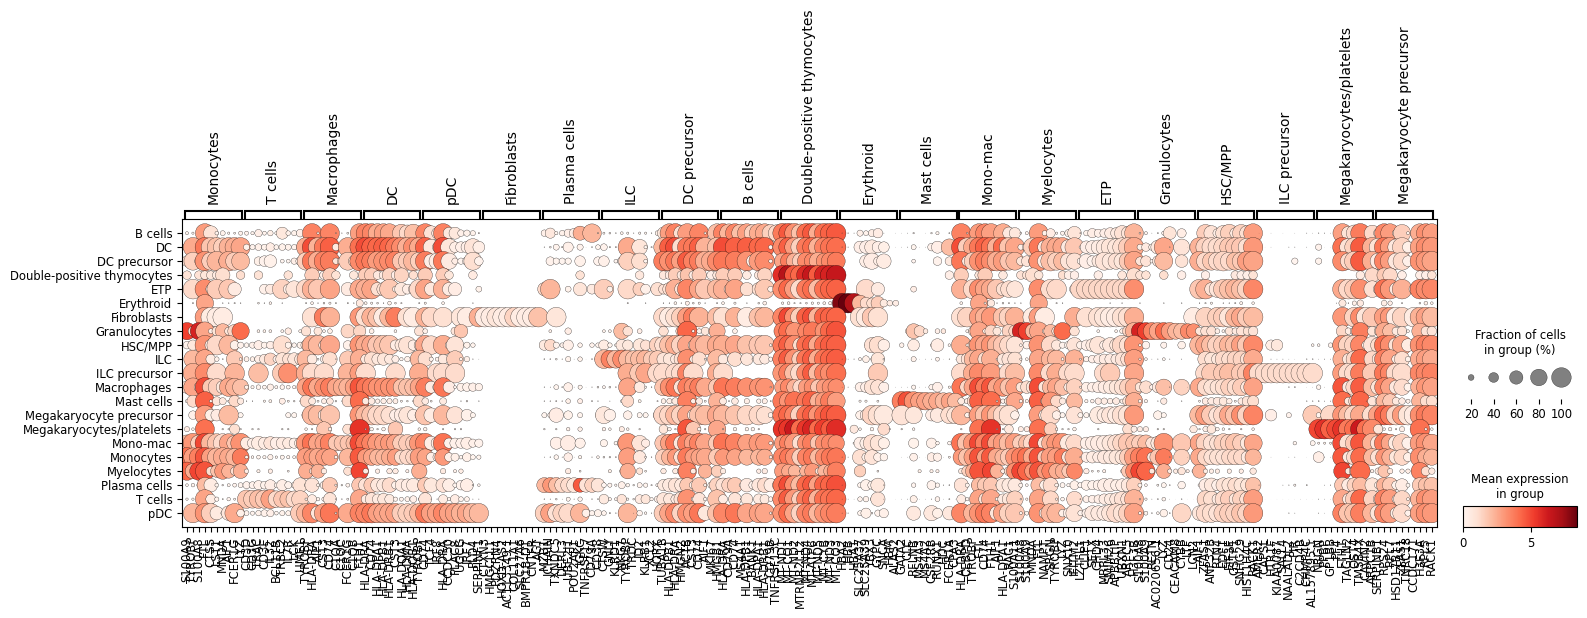

In [17]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="predicted_labels",
    figsize=(18, 4),
)

### Predict labels from new model

In [18]:
models.download_models(force_update=False)
model_name = 'Immune_All_High'
model = models.Model.load(model = model_name+'.pkl') # 'Immune_All_High'

📂 Storing models in C:\Users\giuli\.celltypist\data\models


⏩ Skipping [1/46]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/46]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/46]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [4/46]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [5/46]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [6/46]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [7/46]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [8/46]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [9/46]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [10/46]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [11/46]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [12/46]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [13/46]: Cells_Adult_Breast.pkl (file exists)
⏩ Skipping [14/46]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [15/46]: Cells_Human_Tonsil.pkl (file exists)
⏩ Skipping [16/46]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [17/46]: Cells_Lung_Airway.pk

In [19]:
clustering_score_df = pd.read_csv(RESULTS_FOLDER+'clustering_score.csv') # use same neighbors the model using for transfer labels

row = clustering_score_df[clustering_score_df['silhouette_score'] == clustering_score_df['silhouette_score'].max()]
n_neighbors = row['n_neighbors'].values[0]
resolution = row['resolution'].values[0]
pca_dim = row['pca_dim'].values[0]

sc.pp.neighbors(
    adata,
    n_neighbors=n_neighbors,
    n_pcs=pca_dim,
    knn=True,
    metric='euclidean', # 'correlation'
    random_state=RANDOM_STATE
    )

In [20]:
new_predictions = celltypist.annotate(
    adata,
    model = model_name+'.pkl',
    majority_voting=True,
    mode='best match'
)

🔬 Input data has 110563 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [21]:
new_predictions.predicted_labels.to_csv(RESULTS_FOLDER+'celltypist_labels_GSE194078.csv')

In [22]:
new_predictions.predicted_labels.head()

,predicted_labels,over_clustering,majority_voting
AAACCCACAAGACCGA-1-PBMC,Monocytes,1319,Monocytes
AAACCCACACGGCACT-1-PBMC,T cells,201,T cells
AAACCCATCAGAATAG-1-PBMC,T cells,586,T cells
AAACGAAAGGTAAAGG-1-PBMC,T cells,1600,T cells
AAACGAACACAGCCAC-1-PBMC,T cells,98,T cells


In [23]:
len(new_predictions.predicted_labels['predicted_labels'].unique()) # predicted labels from new model

21

In [24]:
len(predictions.predicted_labels['predicted_labels'].unique()) # transfer labels

23

### Comparison

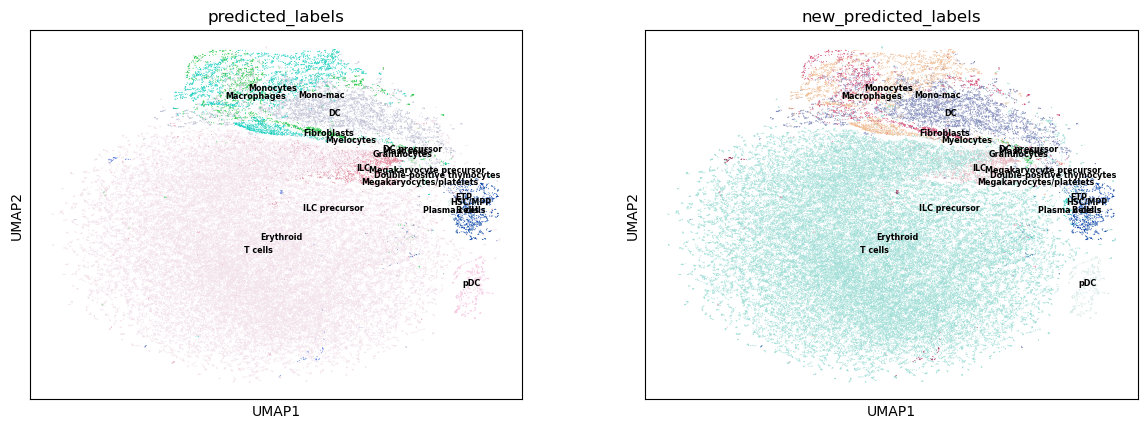

In [25]:
adata.obs['new_predicted_labels'] = new_predictions.predicted_labels['predicted_labels']

sc.tl.umap(adata)
sc.pl.umap(adata, color=['predicted_labels', 'new_predicted_labels'], legend_loc='on data', 
    legend_fontsize='xx-small', color_map='tab20')

In [26]:
# labels in adata.obs['predicted_labels'] and not in adata.obs['new_predicted_labels']
set(adata.obs['predicted_labels'].unique()) - set(adata.obs['new_predicted_labels'].unique())

set()

null set: labes that are different are the one in the clusters with only one cell, so they are deleted

In [27]:
adata.obs['new_predicted_labels'].value_counts()

new_predicted_labels
T cells                       90453
DC                             7673
Monocytes                      4904
Macrophages                    2506
ILC                            1941
B cells                        1546
pDC                             882
Plasma cells                    217
Mast cells                      160
Erythroid                       145
Megakaryocytes/platelets         29
Myelocytes                       22
Mono-mac                         19
DC precursor                     18
HSC/MPP                          14
Granulocytes                     13
Megakaryocyte precursor           6
Double-positive thymocytes        6
ETP                               5
Fibroblasts                       2
ILC precursor                     2
Name: count, dtype: int64

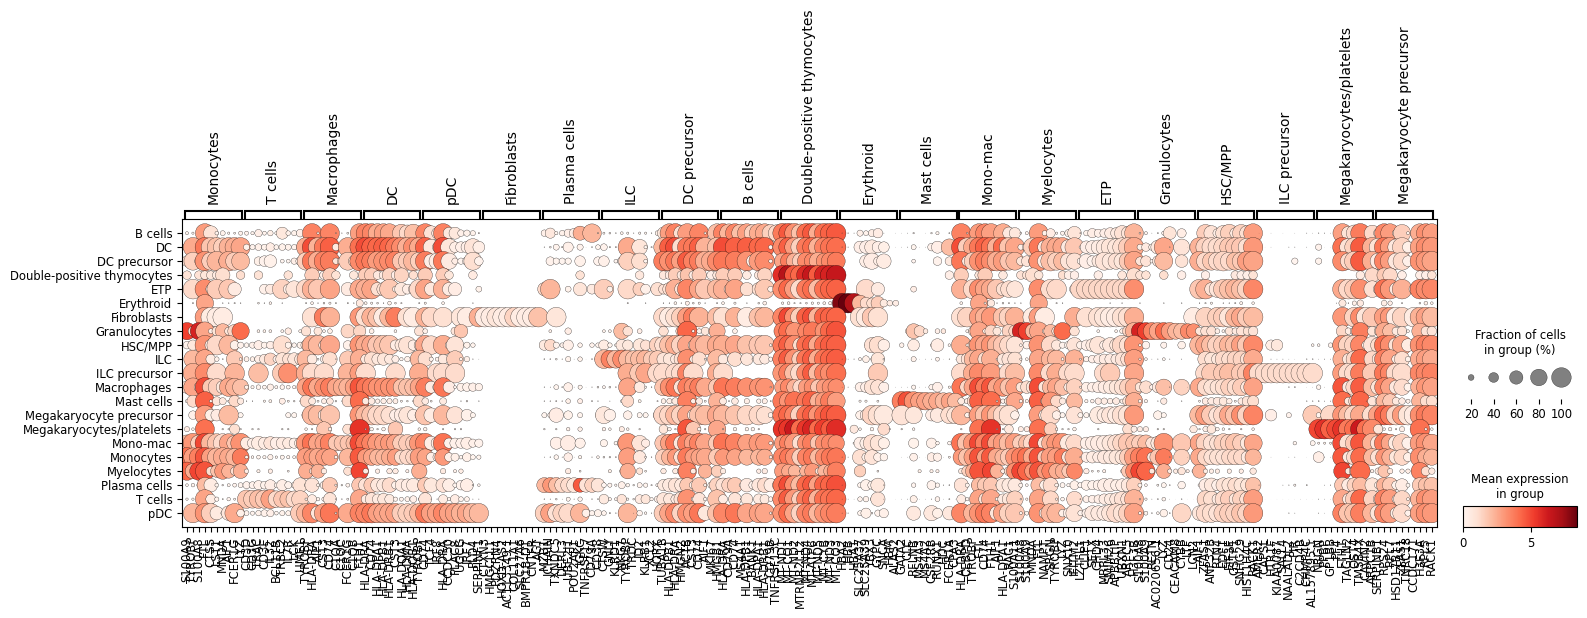

In [28]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="new_predicted_labels",
    figsize=(18, 4),
)

In [29]:
from utils import sankey_plot_with_labels

sankey_plot_with_labels(
    labels=[adata.obs['predicted_labels'], adata.obs['new_predicted_labels']],
    labels_titles=['Labels Trasfered', 'Labels Predicted'],
    title='Celltypist Transfer Labels vs Celltypist Predicted Labels',
)